In [21]:
import pandas as pd

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split

from sklearn.preprocessing import StandardScaler, PowerTransformer

In [22]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        self.ss_X = StandardScaler()
        self.pt_X = PowerTransformer(standardize=True)
        self.ss_y = StandardScaler()
        self.pt_y = PowerTransformer(standardize=True)        
        self.feature_names = feature_names
        self.additional_param = additional_param

    def fit(self, X, y = None):
        self.ss_X.fit(X)
        self.pt_X.fit(self.ss_X.transform(X))
        if (y is not None):
            self.ss_y.fit(y)
            self.pt_y.fit(self.ss_y.transform(y))
        return self

    def transform(self, X, y = None):
        pt_X_ = pd.DataFrame(self.pt_X.fit(pd.DataFrame(self.ss_X.fit(X).transform(X),index=X.index,columns=X.columns)).transform(pd.DataFrame(self.ss_X.fit(X).transform(X),index=X.index,columns=X.columns)),index=X.index,columns=X.columns)        
        if (y is None):
            return pt_X_
        else:
            pt_y_ = pd.DataFrame(self.pt_y.fit(pd.DataFrame(self.ss_y.fit(y).transform(y),index=y.index,columns=y.columns)).transform(pd.DataFrame(self.ss_y.fit(y).transform(y),index=y.index,columns=y.columns)),index=y.index,columns=y.columns)
            return pt_X_, pt_y_
        
    def inverse_transform(self, X, y = None):
        target_X = pd.DataFrame(self.ss_X.inverse_transform(self.pt_X.inverse_transform(X)),index=X.index,columns=X.columns)
        if (y is None):
            return target_X
        else:
            target_y = pd.DataFrame(self.ss_y.inverse_transform(self.pt_y.inverse_transform(y)),index=y.index,columns=y.columns)
            return target_X, target_y
        

In [23]:
target = 'Poverty'
exclude = 'States'

In [24]:
all_data = pd.read_csv('https://raw.githubusercontent.com/thistleknot/python-ml/master/data/raw/states.csv')

In [25]:
train, valid = train_test_split(all_data.index, test_size=0.3, shuffle=True)
valid, test = train_test_split(valid,  test_size=0.5, shuffle=True)

X = all_data[set(all_data.columns).difference([target,exclude])].copy()
y = pd.DataFrame(all_data[target].copy())

X_train = X.loc[train].copy()
X_valid = X.loc[valid].copy()
X_test = X.loc[test].copy()

y_train = y.loc[X_train.index][[target]].copy()
y_valid = y.loc[X_valid.index][[target]].copy()
y_test = y.loc[X_test.index][[target]].copy()

X_train_ss_yj_t = ss_yj_Transformer()
X_train_ss_yj_t.fit(X_train)
X_train_ss_yj = X_train_ss_yj_t.transform(X_train)

y_train_ss_yj_t = ss_yj_Transformer()
y_train_ss_yj_t.fit(y_train)
y_train_ss_yj = y_train_ss_yj_t.transform(y_train)

array([[<AxesSubplot:title={'center':'Poverty'}>]], dtype=object)

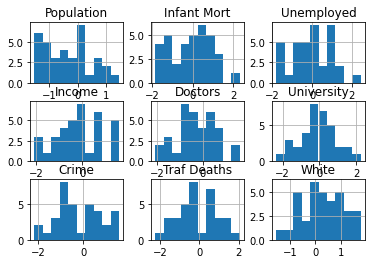

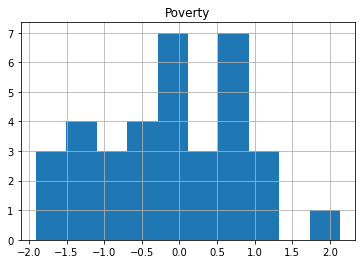

In [26]:
X_train_ss_yj.hist()
y_train_ss_yj.hist()

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

lr = LinearRegression()

sfbs1 = sfbs(lr, 
          k_features=len(X_train.columns), 
          #forward=True, 
          floating=True, 
          scoring='neg_mean_squared_error',
          #scoring='accuracy',
          n_jobs=-1,
          cv=numCV)

pipe = make_pipeline(ss_yj_Transformer(), sfbs1)
pipe.fit(X_train, y_train)
print('best combination (ACC: %.3f): %s\n' % (sfbs1.k_score_, sfbs1.k_feature_idx_))
print('all subsets:\n', sfbs1.subsets_)
plot_sfs(sfbs1.get_metric_dict(), kind='std_err');